# 二値分類モデルの学習

In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn import model_selection
from sklearn import feature_extraction
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

学習に使うデータをロードします。

In [2]:
import pandas as pd
from sklearn import model_selection

# positive, neutral, negative の中から negative なレビューを当てるタスクとして、
# negativeを1に、それ以外のpositive, neutralを0に設定します。
data = pd.read_csv("input/pn_same_judge.csv")
data["label_num"] = data["label"].map({"positive": 0, "neutral": 0, "negative": 1})
train, test = model_selection.train_test_split(data, test_size=0.1, random_state=0)

In [3]:
data.shape, train.shape, test.shape

((4186, 4), (3767, 4), (419, 4))

In [4]:
data.head(n=3)

,label,text,judges,label_num
0,neutral,出張でお世話になりました。,"{""0"": 3}",0
1,neutral,朝食は普通でした。,"{""0"": 3}",0
2,positive,また是非行きたいです。,"{""1"": 3}",0


ラベルの分布をチェックします。

In [5]:
data.groupby("label_num").size()

label_num
0    3584
1     602
dtype: int64

偏りのあるデータセットであることがわかります。

文をトークン化するためのトークナイザを定義します。

In [6]:
import spacy

nlp = spacy.load("ja_core_news_md")

def tokenize(text):
   return [token.lemma_ for token in nlp(text)]

2022-05-09 07:44:01.628082: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-09 07:44:01.628190: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## ナイーブベイズ分類器

[sklearn.naive_bayes.MultinomialNB](https://scikit-learn.org/stable/modules/naive_bayes.html)
を使います。

In [7]:
from sklearn.naive_bayes import MultinomialNB


# 注意：トークナイザもtrainデータセットで学習します
pipe_nb = Pipeline([
    ("vect", TfidfVectorizer(tokenizer=tokenize)),
    ("clf", MultinomialNB())
])

pipe_nb.fit(train["text"], train["label_num"])

Pipeline(steps=[('vect',
                 TfidfVectorizer(tokenizer=<function tokenize at 0x7f56a0231ee0>)),
                ('clf', MultinomialNB())])

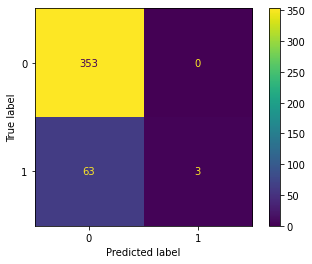

In [8]:
pred_nb = pipe_nb.predict(test["text"])
metrics.ConfusionMatrixDisplay.from_predictions(y_true=test["label_num"], y_pred=pred_nb)

In [9]:
score_nb = pipe_nb.predict_proba(test["text"])[:,1]

## ロジスティック回帰

In [10]:
from sklearn.linear_model import LogisticRegression


pipe_lr = Pipeline([
    ("vect", TfidfVectorizer(tokenizer=tokenize)),
    ("clf", LogisticRegression(random_state=0))
])

pipe_lr.fit(train["text"], train["label_num"])

Pipeline(steps=[('vect',
                 TfidfVectorizer(tokenizer=<function tokenize at 0x7f56a0231ee0>)),
                ('clf', LogisticRegression(random_state=0))])

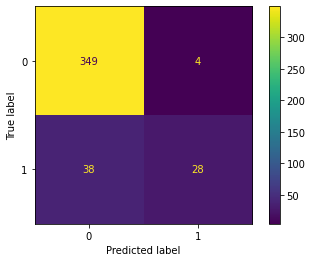

In [11]:
pred_lr = pipe_lr.predict(test["text"])
metrics.ConfusionMatrixDisplay.from_predictions(y_true=test["label_num"], y_pred=pred_lr)

In [12]:
score_lr = pipe_lr.predict_proba(test["text"])[:,1]

## SVC

In [13]:
from sklearn.svm import SVC

pipe_svc = Pipeline([
    ("vect", TfidfVectorizer(tokenizer=tokenize)),
    ("clf", SVC(random_state=0)),
])

pipe_svc.fit(train["text"], train["label_num"])

Pipeline(steps=[('vect',
                 TfidfVectorizer(tokenizer=<function tokenize at 0x7f56a0231ee0>)),
                ('clf', SVC(random_state=0))])

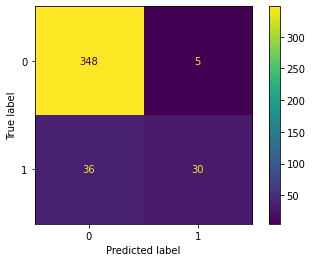

In [14]:
pred_svc = pipe_svc.predict(test["text"])
metrics.ConfusionMatrixDisplay.from_predictions(y_true=test["label_num"], y_pred=pred_svc)

In [15]:
score_svc = pipe_svc.decision_function(test["text"])

## Random Forest

In [16]:
from sklearn.ensemble import RandomForestClassifier

pipe_rf = Pipeline([
    ("vect", TfidfVectorizer(tokenizer=tokenize)),
    ("clf", RandomForestClassifier(random_state=0))
])

pipe_rf.fit(train["text"], train["label_num"])

Pipeline(steps=[('vect',
                 TfidfVectorizer(tokenizer=<function tokenize at 0x7f56a0231ee0>)),
                ('clf', RandomForestClassifier(random_state=0))])

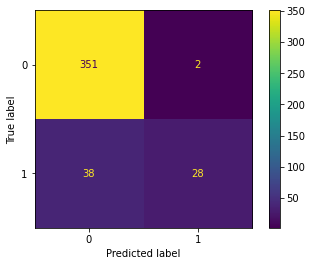

In [17]:
pred_rf = pipe_rf.predict(test["text"])
metrics.ConfusionMatrixDisplay.from_predictions(y_true=test["label_num"], y_pred=pred_rf)

In [18]:
score_rf = pipe_rf.predict_proba(test["text"])[:,1]

## 単語埋め込みを使う

In [19]:
# TransoformerMixinを継承すれば fit_trainsform は fit, transform にあわせて実装される

from sklearn.base import TransformerMixin

class DenseVectorizer(TransformerMixin):
    def __init__(self, nlp):
        self._nlp = nlp
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return np.array([self._nlp(text).vector for text in X])

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

pipe_we = Pipeline([
    ("vect", DenseVectorizer(nlp=nlp)),
    ("clf", LogisticRegression(class_weight="balanced"))
])

pipe_we.fit(train["text"], train["label_num"])

Pipeline(steps=[('vect', <__main__.DenseVectorizer object at 0x7f56948f5df0>),
                ('clf', LogisticRegression(class_weight='balanced'))])

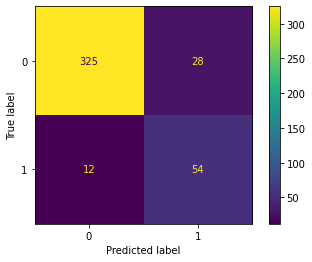

In [21]:
pred_we = pipe_we.predict(test["text"])
metrics.ConfusionMatrixDisplay.from_predictions(y_true=test["label_num"], y_pred=pred_we)

In [22]:
score_we = pipe_we.decision_function(test["text"])

## 文埋め込みを使う

In [23]:
# TransoformerMixinを継承すれば fit_trainsform は fit, transform にあわせて実装される

from sklearn.base import TransformerMixin
import tensorflow_hub as hub
import numpy as np
import tensorflow_text

class UseVectorizer(TransformerMixin):
    def __init__(self):
        self._embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual/3")
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return self._embed(X)

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

pipe_se = Pipeline([
    ("vect", UseVectorizer()),
    ("clf", SVC(random_state=0)),
])

pipe_se.fit(train["text"], train["label_num"])

2022-05-09 07:49:47.119701: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-09 07:49:47.120629: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-09 07:49:47.120773: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (a6a1cdd7a181): /proc/driver/nvidia/version does not exist
2022-05-09 07:49:47.125843: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Pipeline(steps=[('vect', <__main__.UseVectorizer object at 0x7f56936b38e0>),
                ('clf', SVC(random_state=0))])

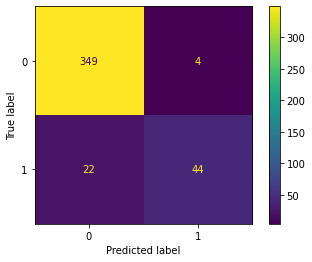

In [25]:
pred_se = pipe_se.predict(test["text"])
metrics.ConfusionMatrixDisplay.from_predictions(y_true=test["label_num"], y_pred=pred_se)

In [26]:
score_se = pipe_se.decision_function(test["text"])

## 参考: PRカーブの比較

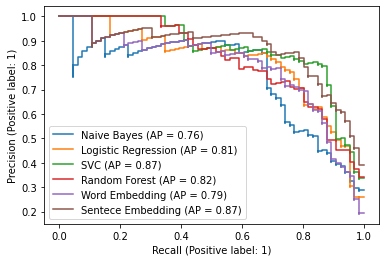

In [27]:
import  matplotlib.pyplot as plt

# subplotsでaxesを取得して同じグラフ上に表示する
_, ax = plt.subplots()
for name, pred in [
    ("Naive Bayes", score_nb),
    ("Logistic Regression", score_lr),
    ("SVC", score_svc),
    ("Random Forest", score_rf),
    ("Word Embedding", score_we),
    ("Sentece Embedding", score_se),
]:
    metrics.PrecisionRecallDisplay.from_predictions(ax=ax, y_true=test["label_num"], y_pred=pred, name=name)